In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from time import time
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression

# Download necessary NLTK packages
try:
    nltk.download('punkt_tab')
except Exception as e:
    print(f"Errore durante il download dei pacchetti NLTK: {e}")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc.csv")

In [3]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Resume_str'])

In [4]:
def preprocess(text):
    tokens = word_tokenize(text)
    return tokens

df['tokens'] = df['Resume_str'].apply(preprocess)

In [5]:
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, epochs=10)

In [6]:
print(f"Numero di parole nel vocabolario Word2Vec: {len(w2v_model.wv.index_to_key)}")

Numero di parole nel vocabolario Word2Vec: 22834


In [7]:
def advanced_pooling_weighted(vectors, weights):
    weights = np.array(weights)
    weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)

    weighted_mean = np.average(vectors, axis=0, weights=weights)
    max_ = np.max(vectors, axis=0)
    min_ = np.min(vectors, axis=0)
    var_ = np.var(vectors, axis=0)
    std_ = np.std(vectors, axis=0)
    median = np.median(vectors, axis=0)
    q25 = np.percentile(vectors, 25, axis=0)
    q75 = np.percentile(vectors, 75, axis=0)

    return np.concatenate([weighted_mean, max_, min_, var_, std_, median, q25, q75])

def get_advanced_weighted_vector(tokens, model, tfidf_vectorizer, tfidf_row, vector_size=50):
    word2idx = tfidf_vectorizer.vocabulary_
    vectors = []
    weights = []

    for word in tokens:
        if word in model.wv and word in word2idx:
            vectors.append(model.wv[word])
            weights.append(tfidf_row[0, word2idx[word]])

    if len(vectors) == 0:
        return np.zeros(8 * vector_size)  # 8 statistiche usate

    return advanced_pooling_weighted(np.array(vectors), weights)

# 7. Applica la trasformazione a tutti i documenti
df['vector'] = [
    get_advanced_weighted_vector(row['tokens'], w2v_model, tfidf_vectorizer, tfidf_matrix[i], vector_size=50)
    for i, row in df.iterrows()
]

In [8]:
X = np.vstack(df['vector'].values)
y = df['Category']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986, 800)
Validation data size: (497, 800)


### Support Vector Classifier

In [11]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
class_counts = y_train.value_counts()
min_classes = class_counts[class_counts < class_counts.mean()].index.tolist()

print(f"Applicazione di SMOTE alle classi: {min_classes}")

target_size = int(class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applicazione di SMOTE alle classi: ['ARTS', 'TEACHER', 'APPAREL', 'DIGITAL-MEDIA', 'AGRICULTURE', 'AUTOMOBILE', 'BPO']


In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

In [15]:
param_grid = [
    {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    }
]

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(X_train, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 17.66 seconds for 4 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.537 (std: 0.013)
Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 2
Mean validation score: 0.528 (std: 0.019)
Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.519 (std: 0.019)
Parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 4
Mean validation score: 0.506 (std: 0.021)
Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}



In [16]:
print(grid_search.best_params_)

{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [17]:
# DataFrame con i risultati
results = pd.DataFrame(grid_search.cv_results_)
param_cols = [col for col in results.columns if col.startswith("param_")]

# Converti tutti i parametri in stringa per la pivot table
for p in param_cols:
    results[p] = results[p].astype(str)

# Heatmap per ogni coppia di parametri
for p1, p2 in combinations(param_cols, 2):
    try:
        pivot_val = results.pivot_table(values='mean_test_score', index=p1, columns=p2)
        pivot_train = results.pivot_table(values='mean_train_score', index=p1, columns=p2)

        if pivot_val.shape[0] > 1 and pivot_val.shape[1] > 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            sns.heatmap(pivot_train, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
            axes[0].set_title(f"Train Score")
            axes[0].set_xlabel(p2.replace("param_", ""))
            axes[0].set_ylabel(p1.replace("param_", ""))

            sns.heatmap(pivot_val, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
            axes[1].set_title(f"Validation Score")
            axes[1].set_xlabel(p2.replace("param_", ""))
            axes[1].set_ylabel("")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Errore con {p1} e {p2}: {e}")

In [18]:
LR_Model_best = grid_search.best_estimator_
prediction = LR_Model_best.predict(X_test)

In [19]:
print("Training Score: {:.2f}".format(LR_Model_best.score(X_train, y_train)))
print("Test Score: {:.2f}".format(LR_Model_best.score(X_test, y_test)))

Training Score: 0.87
Test Score: 0.56


In [20]:
print(classification_report(y_test, prediction, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.63      0.79      0.70        24
              ADVOCATE       0.32      0.38      0.35        24
           AGRICULTURE       0.40      0.46      0.43        13
               APPAREL       0.31      0.26      0.29        19
                  ARTS       0.47      0.33      0.39        21
            AUTOMOBILE       0.29      0.29      0.29         7
              AVIATION       0.68      0.54      0.60        24
               BANKING       0.60      0.65      0.62        23
                   BPO       0.14      0.25      0.18         4
  BUSINESS-DEVELOPMENT       0.47      0.71      0.57        24
                  CHEF       0.79      0.62      0.70        24
          CONSTRUCTION       0.62      0.59      0.60        22
            CONSULTANT       0.27      0.17      0.21        23
              DESIGNER       0.71      0.71      0.71        21
         DIGITAL-MEDIA       0.54      

<Figure size 1500x1000 with 0 Axes>

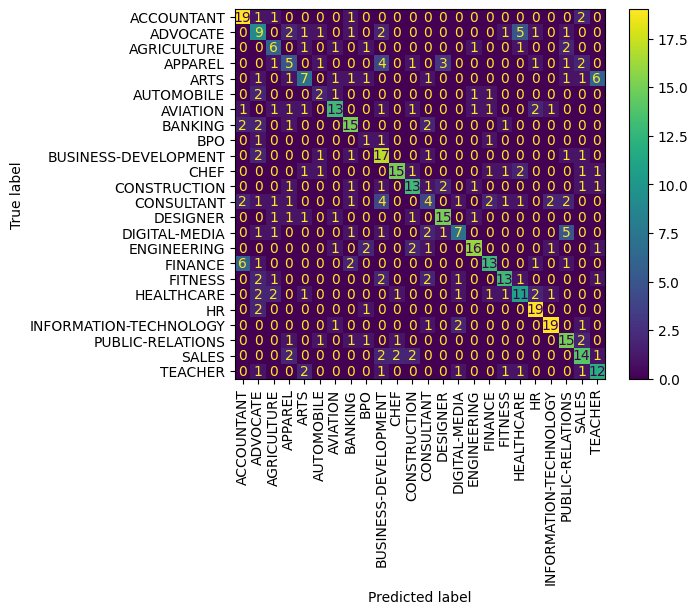

In [21]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

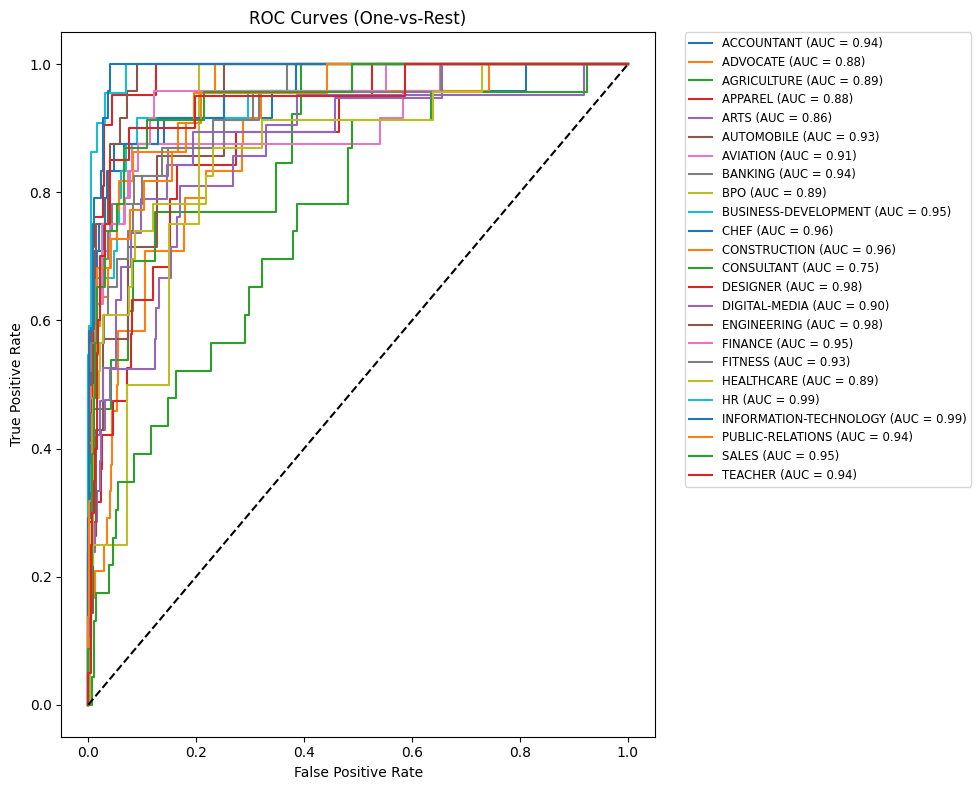

In [22]:
y_test_bin = label_binarize(y_test, classes=LR_Model_best.classes_)
y_score = LR_Model_best.predict_proba(X_test)

plt.figure(figsize=(10, 8))

for i in range(len(LR_Model_best.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{LR_Model_best.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")

# Sposta la legenda fuori dal grafico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

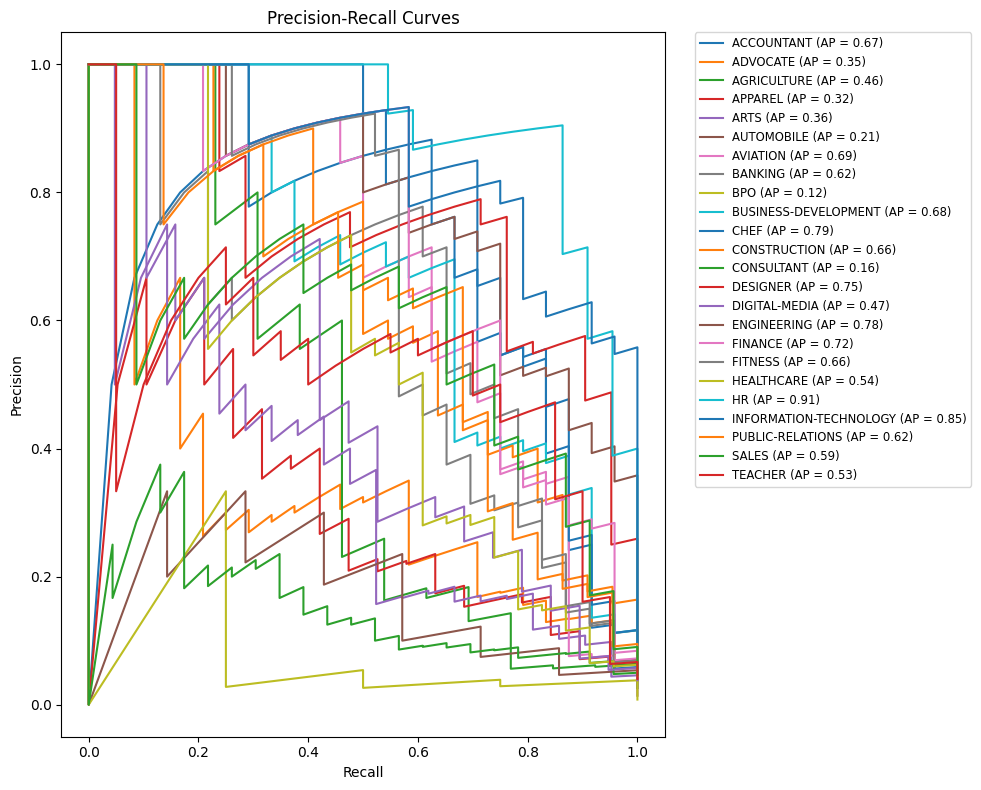

In [23]:
plt.figure(figsize=(10, 8))

for i in range(len(LR_Model_best.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{LR_Model_best.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")

# Legenda esterna a destra
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

In [24]:
# --- Dopo aver calcolato best_estimator_ e le accuracy ---

# Parametri del TF-IDF
w2v_descr = (
    f"D2V("
    f"vector_size={w2v_model.vector_size}, "
    f"window={w2v_model.window}, "
    f"min_count={w2v_model.min_count}, "
    f"epochs={w2v_model.epochs}"
    f")"
)

# Modello e suoi parametri
best_clf = grid_search.best_estimator_.named_steps['clf']
model_name = type(best_clf).__name__
model_params = best_clf.get_params()
model_descr = f"{model_name}(" + ", ".join(f"{k}={v}" for k, v in model_params.items() if k in grid_search.best_params_) + ")"

# Accuracy su train e test
train_acc = LR_Model_best.score(X_train, y_train)
test_acc  = LR_Model_best.score(X_test, y_test)

# Costruisci la riga da scrivere
log_line = (
    f"{model_descr} | "
    f"{w2v_descr} | "
    f"Accuracy train={train_acc:.3f}, test={test_acc:.3f}\n"
)

# Scrivi (append) su file
with open("../experiment_log.txt", "a") as log_file:
    log_file.write(log_line)

print("Riga di log aggiunta in 'experiment_log.txt':")
print(log_line)


Riga di log aggiunta in 'experiment_log.txt':
LogisticRegression() | D2V(vector_size=100, window=5, min_count=2, epochs=10) | Accuracy train=0.872, test=0.563



In [25]:
import sys
sys.path.append('..')

from utils import save_experiment_W2V

save_experiment_W2V(w2v_model, grid_search, LR_Model_best, X_train, y_train, X_test, y_test)

⚠️ Riga già presente nel file, non verrà aggiunta.
